<a href="https://colab.research.google.com/github/namwootree/Portfolio/blob/main/Competition/Kaggle/Scrabble%20Player%20Rating/Catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

## Install

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 4.6 MB/s 
     |████████████████████████████████| 209 kB 43.3 MB/s 
     |████████████████████████████████| 78 kB 3.5 MB/s 
     |████████████████████████████████| 50 kB 3.6 MB/s 
     |████████████████████████████████| 147 kB 15.1 MB/s 
     |████████████████████████████████| 112 kB 37.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=7c1aedfc0a9dc6473f444a955582e2ad12760449e3c84e207fc622eb535260ea
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 23 kB/s 


## Library

In [10]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
import os


from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, GroupKFold

from catboost import CatBoostRegressor
from catboost import Pool, cv

import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

# Load Data

## Google Drive Mount

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip File

## Load Train / Test Set

In [28]:
X = pd.read_csv('/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/X_train.csv')
y = pd.read_csv('/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/y_train.csv')
y = y['rating']
X_test = pd.read_csv('/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/X_test.csv')

# Modeling

## Optuna

In [29]:
groups = X.pop('nickname')

In [19]:
def objective(trial, X, y):

    cv_dataset = Pool(data=X,
                   label=y)
    
    # 적용(수색)할 최적의 하이퍼 파라미터 범위 지정
    param = {
    'loss_function':'RMSE',
    'depth':7,
    'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
    #"max_depth":trial.suggest_int("max_depth", 4, 16),
    'random_strength' :trial.suggest_int('random_strength', 0, 126),
    'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
    "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.3, 1.0),
    "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
    "min_child_samples": trial.suggest_int("min_child_samples", 1, 512),
    "max_bin": trial.suggest_int("max_bin", 100, 512)
    }

    folds = GroupKFold(n_splits=5).split(X, y, groups=groups)

    scores = cv(cv_dataset,
                param,
                folds= folds,
                verbose=100,                   
                early_stopping_rounds=100, 
                num_boost_round=50000)
    
    cv_score = list(scores['test-RMSE-mean'])[-1]

    # Return metric of interest
    return cv_score

In [21]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X, y),
               timeout=1800,
               n_trials=100,
               n_jobs=1,
               show_progress_bar=True) 

  0%|          | 0/100 [00:00<?, ?it/s]

Training on fold [0/5]
0:	learn: 1797.0713886	test: 1551.6727713	best: 1551.6727713 (0)	total: 46ms	remaining: 38m 21s
100:	learn: 151.2704084	test: 98.5387061	best: 98.5387061 (100)	total: 4.48s	remaining: 36m 53s
200:	learn: 99.7899626	test: 91.3836822	best: 91.3836822 (200)	total: 8.75s	remaining: 36m 7s
300:	learn: 90.9416152	test: 84.3413161	best: 84.3413161 (300)	total: 12.9s	remaining: 35m 29s
400:	learn: 85.1465291	test: 82.8288539	best: 82.8000161 (398)	total: 17s	remaining: 34m 57s
500:	learn: 77.1631852	test: 81.9027338	best: 81.8452977 (498)	total: 21.8s	remaining: 35m 57s
600:	learn: 71.0326338	test: 81.6750229	best: 81.6293076 (599)	total: 31.8s	remaining: 43m 32s
700:	learn: 67.1746189	test: 81.3216945	best: 81.2892651 (689)	total: 40.2s	remaining: 47m 5s
800:	learn: 63.9392983	test: 80.9121684	best: 80.9017396 (797)	total: 48.9s	remaining: 50m 4s
900:	learn: 61.3626754	test: 80.8456404	best: 80.8011540 (867)	total: 53.5s	remaining: 48m 34s
1000:	learn: 59.2713179	test: 

In [22]:
print(study.best_params)

{'bagging_temperature': 18.81204808261991, 'random_strength': 101, 'subsample': 0.04452446157452753, 'colsample_bylevel': 0.505615406777333, 'l2_leaf_reg': 6.479506979770803e-06, 'min_child_samples': 289, 'max_bin': 429}


In [23]:
print(study.best_value)

101.6234589347202


In [24]:
optuna.visualization.plot_param_importances(study)

In [25]:
optuna.visualization.plot_optimization_history(study)

## Group KFold

In [30]:
preds = []

test_groups = X_test.pop('nickname') 

skf = GroupKFold(n_splits=5)

num_fold = 0

for repeat in range(3):

  for fold_idx, (train_index, valid_index) in enumerate(tqdm(skf.split(X, y, groups=groups))):
      X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
      y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

      cat_params = {
          'verbose': 500,
          'n_estimators': 50000,
          **study.best_params
      }

      print(f'\nNumber fold : {num_fold}\n')

      model = CatBoostRegressor(**cat_params,
                                task_type='CPU')

      model.fit(X_train, y_train,
                eval_set=(X_valid, y_valid),
                early_stopping_rounds=100,
                use_best_model=True,
                verbose=100)
      
      y_pred = model.predict(X_valid)

      score = mean_squared_error(y_valid, y_pred, squared=False)

      print("\nFold {} MSE Score: {}\n".format(fold_idx, score))
      print("\n----------------------\n")

      preds.append( model.predict(X_test))

      num_fold += 1

0it [00:00, ?it/s]


Number fold : 0

0:	learn: 210.0158209	test: 302.9534753	best: 302.9534753 (0)	total: 37ms	remaining: 30m 50s
100:	learn: 113.7529476	test: 202.9090583	best: 202.5270599 (99)	total: 2.56s	remaining: 21m 2s
200:	learn: 99.7210443	test: 163.4351297	best: 162.1075789 (186)	total: 4.99s	remaining: 20m 36s
300:	learn: 93.7751065	test: 164.2102909	best: 160.6996318 (241)	total: 7.38s	remaining: 20m 19s
400:	learn: 89.1892235	test: 160.0457306	best: 157.3844934 (362)	total: 9.81s	remaining: 20m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 157.3844934
bestIteration = 362

Shrink model to first 363 iterations.

Fold 0 MSE Score: 157.3844934392739


----------------------


Number fold : 1

0:	learn: 229.6020011	test: 213.1689524	best: 213.1689524 (0)	total: 23.6ms	remaining: 19m 39s
100:	learn: 111.1066191	test: 126.8479868	best: 126.8479868 (100)	total: 2.69s	remaining: 22m 7s
200:	learn: 96.0360174	test: 113.7704696	best: 113.6810121 (198)	total: 5.35s	remaining: 22

0it [00:00, ?it/s]


Number fold : 5

0:	learn: 210.0158209	test: 302.9534753	best: 302.9534753 (0)	total: 30.4ms	remaining: 25m 20s
100:	learn: 113.7529476	test: 202.9090583	best: 202.5270599 (99)	total: 2.63s	remaining: 21m 37s
200:	learn: 99.7210443	test: 163.4351297	best: 162.1075789 (186)	total: 5.2s	remaining: 21m 29s
300:	learn: 93.7751065	test: 164.2102909	best: 160.6996318 (241)	total: 7.68s	remaining: 21m 8s
400:	learn: 89.1892235	test: 160.0457306	best: 157.3844934 (362)	total: 10.2s	remaining: 21m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 157.3844934
bestIteration = 362

Shrink model to first 363 iterations.

Fold 0 MSE Score: 157.3844934392739


----------------------


Number fold : 6

0:	learn: 229.6020011	test: 213.1689524	best: 213.1689524 (0)	total: 24.5ms	remaining: 20m 27s
100:	learn: 111.1066191	test: 126.8479868	best: 126.8479868 (100)	total: 2.76s	remaining: 22m 43s
200:	learn: 96.0360174	test: 113.7704696	best: 113.6810121 (198)	total: 5.57s	remaining: 2

0it [00:00, ?it/s]


Number fold : 10

0:	learn: 210.0158209	test: 302.9534753	best: 302.9534753 (0)	total: 23.6ms	remaining: 19m 41s
100:	learn: 113.7529476	test: 202.9090583	best: 202.5270599 (99)	total: 2.52s	remaining: 20m 47s
200:	learn: 99.7210443	test: 163.4351297	best: 162.1075789 (186)	total: 4.99s	remaining: 20m 35s
300:	learn: 93.7751065	test: 164.2102909	best: 160.6996318 (241)	total: 7.49s	remaining: 20m 36s
400:	learn: 89.1892235	test: 160.0457306	best: 157.3844934 (362)	total: 10s	remaining: 20m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 157.3844934
bestIteration = 362

Shrink model to first 363 iterations.

Fold 0 MSE Score: 157.3844934392739


----------------------


Number fold : 11

0:	learn: 229.6020011	test: 213.1689524	best: 213.1689524 (0)	total: 26.2ms	remaining: 21m 49s
100:	learn: 111.1066191	test: 126.8479868	best: 126.8479868 (100)	total: 2.74s	remaining: 22m 34s
200:	learn: 96.0360174	test: 113.7704696	best: 113.6810121 (198)	total: 5.47s	remaining

# Submission

In [31]:
final_preds = np.mean(preds, axis=0)

Text(0.5, 1.0, 'Distribution of Predicted Ratings')

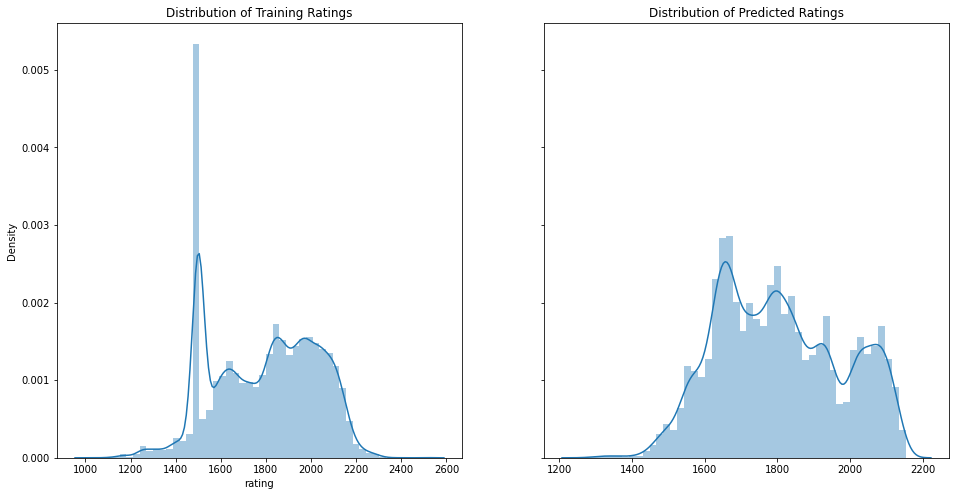

In [32]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,8))
sns.distplot(y, ax=axs[0])
axs[0].set_title("Distribution of Training Ratings")
sns.distplot(final_preds , ax=axs[1])
axs[1].set_title("Distribution of Predicted Ratings")

In [33]:
X_test['rating'] = final_preds
submission = X_test[['game_id', 'rating']].set_index('game_id')

path_save = '/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/submission/'
submission.to_csv(path_save + "CAT_1.csv")

In [34]:
submission

,rating
game_id,
2,2005.300376
7,1943.219213
11,1737.442862
14,1844.548695
27,2084.881624
...,...
72760,2088.942304
72761,1729.583678
72762,1602.630934
